# 🎬 YouTube Comment Sentiment Analysis

This project explores how sentiment in top YouTube comments relates to video popularity.  
We use both traditional machine learning models and transformer-based NLP models to classify comment sentiment and analyze its correlation with views and likes.

**Goals:**
- Predict comment sentiment using ML and Hugging Face models
- Compare model performance using accuracy and F1 score
- Investigate whether positive sentiment aligns with higher engagement


In [5]:
!pip install transformers datasets scikit-learn pandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

In [1]:
import pandas as pd

comments_df = pd.read_csv('/content/drive/MyDrive/comments.csv')
videos_df = pd.read_csv('/content/drive/MyDrive/videos-stats.csv')

merged_df = pd.merge(comments_df, videos_df[['Video ID', 'Title', 'Views', 'Likes']], on='Video ID')

merged_df.head()

,Unnamed: 0,Video ID,Comment,Likes_x,Sentiment,Title,Views,Likes_y
0,0,wAZZ-UWGVHI,Let's not forget that Apple Pay in 2014 requir...,95.0,1.0,Apple Pay Is Killing the Physical Wallet After...,135612.0,3407.0
1,1,wAZZ-UWGVHI,Here in NZ 50% of retailers don’t even have co...,19.0,0.0,Apple Pay Is Killing the Physical Wallet After...,135612.0,3407.0
2,2,wAZZ-UWGVHI,I will forever acknowledge this channel with t...,161.0,2.0,Apple Pay Is Killing the Physical Wallet After...,135612.0,3407.0
3,3,wAZZ-UWGVHI,Whenever I go to a place that doesn’t take App...,8.0,0.0,Apple Pay Is Killing the Physical Wallet After...,135612.0,3407.0
4,4,wAZZ-UWGVHI,"Apple Pay is so convenient, secure, and easy t...",34.0,2.0,Apple Pay Is Killing the Physical Wallet After...,135612.0,3407.0


### 🧹 Cleaning and Mapping Sentiment Labels

We first filter the dataset to retain only rows with valid sentiment labels (0, 1, or 2). Then, we map these numeric labels to human-readable strings:

- 0 → `negative`
- 1 → `neutral`
- 2 → `positive`

This new column, `Sentiment_Label`, will be used as the target variable for classification.


In [2]:
# Clean and map sentiment
comments_df = comments_df[comments_df['Sentiment'].isin([0, 1, 2])].copy()
comments_df['Sentiment_Label'] = comments_df['Sentiment'].map({0: 'negative', 1: 'neutral', 2: 'positive'})

### 🤖 Zero-Shot Sentiment Classification with BART

We use Hugging Face's `facebook/bart-large-mnli` model to perform zero-shot sentiment classification on YouTube comments. This approach does not require any additional training or fine-tuning.

- **Pipeline**: `zero-shot-classification`
- **Candidate Labels**: `negative`, `neutral`, `positive`

The `batch_predict_zero_shot` function processes comment text in batches, returning the most probable sentiment label for each comment.


In [3]:
from transformers import pipeline

zero_shot = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0)

# Define candidate labels
labels = ["negative", "neutral", "positive"]

def batch_predict_zero_shot(batch):
    results = zero_shot(batch['Comment'], candidate_labels=labels)
    preds = [r['labels'][0] for r in results]
    return {'ZeroShot_Prediction': preds}

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


### ⚡ Efficient Batch Inference with `datasets.Dataset`

To speed up zero-shot classification, we convert the comments DataFrame into a Hugging Face `Dataset` object. This allows batch processing on GPU for faster inference.

- We extract the `Comment` column and convert it to string format.
- The dataset is processed in batches of 16 using `map()` with the previously defined `batch_predict_zero_shot` function.
- Finally, the predicted labels are added back to the original DataFrame as a new column: `ZeroShot_Prediction`.


In [6]:
from datasets import Dataset

# Subset with required columns (convert all to string to be safe)
comments_subset = comments_df[['Comment']].astype(str)
hf_dataset = Dataset.from_pandas(comments_subset)

In [7]:
hf_dataset = hf_dataset.map(batch_predict_zero_shot, batched=True, batch_size=16)
# Join back with original df
comments_df['ZeroShot_Prediction'] = hf_dataset['ZeroShot_Prediction']

Map:   0%|          | 0/18409 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


### 📏 Zero-Shot Model Evaluation Metrics

We evaluate the performance of the zero-shot BART model by comparing its predictions (`ZeroShot_Prediction`) with the ground truth sentiment labels (`Sentiment_Label`).

The following metrics are computed using `scikit-learn`:
- **Accuracy**: Overall correctness of predictions
- **F1 Score (weighted)**: Balance between precision and recall, adjusted for class imbalance
- **Precision**: Correctly predicted positives out of total predicted positives
- **Recall**: Correctly predicted positives out of actual positives

A full classification report is also printed for a detailed breakdown of performance across sentiment classes.


In [14]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

# Ground truth and prediction
y_true = comments_df['Sentiment_Label']
y_pred = comments_df['ZeroShot_Prediction']


# Compute scores
print("Classification Report:\n")
print(classification_report(y_true, y_pred))

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Classification Report:

              precision    recall  f1-score   support

    negative       0.37      0.90      0.52      2338
     neutral       0.64      0.04      0.07      4639
    positive       0.82      0.89      0.85     11432

    accuracy                           0.68     18409
   macro avg       0.61      0.61      0.48     18409
weighted avg       0.72      0.68      0.62     18409

Accuracy: 0.68
F1 Score: 0.62
Precision: 0.72
Recall: 0.68


### 🤖 Sentiment Classification Using Fine-Tuned RoBERTa

We use the `cardiffnlp/twitter-roberta-base-sentiment` model from Hugging Face to classify YouTube comments into sentiment categories. This RoBERTa model is pre-trained and fine-tuned specifically for sentiment analysis on social media text.

- The `TextClassificationPipeline` is set up with truncation to handle input length limits (max 512 tokens).
- The `predict_transformer_sentiment` function uses this pipeline to return the predicted sentiment label (`positive`, `neutral`, or `negative`) for a given text input.


In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TextClassificationPipeline
import torch

# Load fine-tuned model
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

sentiment_pipe = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    return_all_scores=False,
    device=0,
    truncation=True,
    max_length=512
)
def predict_transformer_sentiment(text):
    result = sentiment_pipe(text)
    return result[0]['label'].lower()


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [16]:
comments_df['Transformer_Prediction'] = comments_df['Comment'].astype(str).apply(predict_transformer_sentiment)

### 🔁 Mapping RoBERTa Output Labels

The RoBERTa model returns sentiment predictions in the form of string labels like `label_0`, `label_1`, and `label_2`.  
We map these to human-readable sentiment labels.

This makes the predictions easier to interpret and consistent with the ground truth labels in the dataset.


In [ ]:
label_mapping = {
    'label_0': 'negative',
    'label_1': 'neutral',
    'label_2': 'positive'
}

comments_df['Transformer_Prediction'] = comments_df['Transformer_Prediction'].map(label_mapping)

### ✅ RoBERTa Model Evaluation

We evaluate the predictions from the RoBERTa sentiment classifier against the true sentiment labels using standard classification metrics. The classification report provides a detailed breakdown by class, and we also compute overall accuracy, F1 score, precision, and recall.

The results help assess how well the fine-tuned transformer performs on YouTube comment sentiment.


In [12]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

# Ground truth and prediction
y_true = comments_df['Sentiment_Label']
y_pred = comments_df['Transformer_Prediction']

# Compute scores
print("Classification Report:\n")
print(classification_report(y_true, y_pred))

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Classification Report:

              precision    recall  f1-score   support

    negative       0.98      0.98      0.98      2338
     neutral       0.98      0.98      0.98      4639
    positive       0.99      1.00      1.00     11432

    accuracy                           0.99     18409
   macro avg       0.99      0.98      0.99     18409
weighted avg       0.99      0.99      0.99     18409

Accuracy: 0.99
F1 Score: 0.99
Precision: 0.99
Recall: 0.99


### 💾 Saving Results

We save the final DataFrame, including all sentiment predictions and metadata, to a CSV file named `youtube_sentiment_results.csv`. This allows for easy sharing, analysis, or future use.


In [11]:
comments_df.to_csv('youtube_sentiment_results.csv', index=False)

### 🧼 Text Preprocessing for Traditional ML Models

To prepare the comment text for TF-IDF-based models, we apply a cleaning function that performs the following steps:

- Converts text to lowercase
- Removes URLs, punctuation, and numbers
- Filters out stopwords
- Applies lemmatization using WordNet

The result is stored in a new column `Cleaned_Comment`, which is used as input for the traditional machine learning classifiers.


In [18]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_comment(text):
    text = text.lower()

    # Remove URLs
    text = re.sub(r"http\\S+|www\\S+|https\\S+", '', text, flags=re.MULTILINE)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\\d+', '', text)

    # Remove stopwords and lemmatize
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]

    return ' '.join(words)

comments_df['Cleaned_Comment'] = comments_df['Comment'].astype(str).apply(clean_comment)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


### 🔍 Traditional ML Model Training and Evaluation

We train and evaluate four baseline machine learning models using TF-IDF vectorized comment text as input:

- Logistic Regression
- Linear SVM
- Random Forest
- Naive Bayes

Steps involved:
1. **Split** the cleaned dataset into training and test sets (80/20).
2. **Vectorize** the text using TF-IDF with a vocabulary size of 5000.
3. **Train** each model on the training set.
4. **Evaluate** performance using accuracy and weighted F1 score on the test set.
5. Store results for comparison with transformer models.

The printed classification reports provide detailed metrics for each sentiment class.


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# Features and labels
X = comments_df['Cleaned_Comment']
y = comments_df['Sentiment_Label']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

model_names = []
accuracies = []
f1_scores = []

models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Linear SVM": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Naive Bayes": MultinomialNB()
}

# Train and evaluate each model
for name, model in models.items():
    print(f"\n----- {name} -----")
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    model_names.append(name)
    accuracies.append(acc)
    f1_scores.append(f1)
    print(classification_report(y_test, y_pred))


----- Logistic Regression -----
              precision    recall  f1-score   support

    negative       0.68      0.35      0.46       468
     neutral       0.61      0.58      0.59       928
    positive       0.80      0.90      0.85      2286

    accuracy                           0.75      3682
   macro avg       0.70      0.61      0.63      3682
weighted avg       0.74      0.75      0.74      3682


----- Linear SVM -----
              precision    recall  f1-score   support

    negative       0.57      0.47      0.51       468
     neutral       0.59      0.57      0.58       928
    positive       0.83      0.87      0.85      2286

    accuracy                           0.74      3682
   macro avg       0.66      0.64      0.65      3682
weighted avg       0.73      0.74      0.74      3682


----- Random Forest -----
              precision    recall  f1-score   support

    negative       0.64      0.19      0.29       468
     neutral       0.63      0.55      0.59  

### 📈 Sentiment vs Engagement Analysis

To examine whether positive sentiment in comments is associated with higher engagement, we:

1. **Mapped** sentiment predictions (`negative`, `neutral`, `positive`) to numeric scores (0, 1, 2).
2. **Calculated** the average sentiment score per video based on its top comments.
3. **Merged** this data with `videos-stats.csv` to obtain corresponding views and likes.
4. **Filtered** out videos with unavailable engagement metrics (i.e., `Likes` or `Views` = -1).
5. **Computed** Pearson correlation between average comment sentiment and both views and likes.

The results indicate the strength of linear association between comment sentiment and video popularity.


In [22]:
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

comments_df = pd.read_csv("youtube_sentiment_results.csv")

# Assign numerical sentiment score
score_map = {'negative': 0, 'neutral': 1, 'positive': 2}
comments_df['Sentiment_Score'] = comments_df['Transformer_Prediction'].map(score_map)

videos_df = pd.read_csv('videos-stats.csv')

# Compute average sentiment score per video
avg_sentiment = comments_df.groupby('Video ID')['Sentiment_Score'].mean().reset_index()
avg_sentiment.columns = ['Video ID', 'Avg_Comment_Sentiment']


# Merge with videos_df
merged_df = pd.merge(videos_df, avg_sentiment, on='Video ID')
print(merged_df.head())
# Remove rows with -1 in likes or views
merged_df = merged_df[(merged_df['Likes'] >= 0) & (merged_df['Views'] >= 0)]

# Correlation analysis
views_corr, _ = pearsonr(merged_df['Avg_Comment_Sentiment'], merged_df['Views'])
likes_corr, _ = pearsonr(merged_df['Avg_Comment_Sentiment'], merged_df['Likes'])

print(f"Correlation between average comment sentiment and views: {views_corr:.3f}")
print(f"Correlation between average comment sentiment and likes: {likes_corr:.3f}")

   Unnamed: 0                                              Title     Video ID  \
0           0  Apple Pay Is Killing the Physical Wallet After...  wAZZ-UWGVHI   
1           1                    The most EXPENSIVE thing I own.  b3x28s61q3c   
2           2                 My New House Gaming Setup is SICK!  4mgePWWCAmA   
3           3  Petrol Vs Liquid Nitrogen | Freezing Experimen...  kXiYSI7H2b0   
4           4                     Best Back to School Tech 2022!  ErMwWXQxHp0   

  Published At Keyword    Likes  Comments      Views  Avg_Comment_Sentiment  
0   2022-08-23    tech   3407.0     672.0   135612.0                    1.2  
1   2022-08-24    tech  76779.0    4306.0  1758063.0                    1.8  
2   2022-08-23    tech  63825.0    3338.0  1564007.0                    1.9  
3   2022-08-23    tech  71566.0    1426.0   922918.0                    1.6  
4   2022-08-08    tech  96513.0    5155.0  1855644.0                    1.5  
Correlation between average comment sentiment

### 📊 Visualizing Sentiment vs Engagement

We generate two scatter plots to visualize the relationship between average comment sentiment and video engagement:

- **Sentiment vs Views**
- **Sentiment vs Likes**

These plots help illustrate whether videos with more positive top comments receive higher views or likes.  
Each plot is saved as a PNG image for later inclusion in reports:

- `avg_sentiment_vs_views.png`
- `avg_sentiment_vs_likes.png`


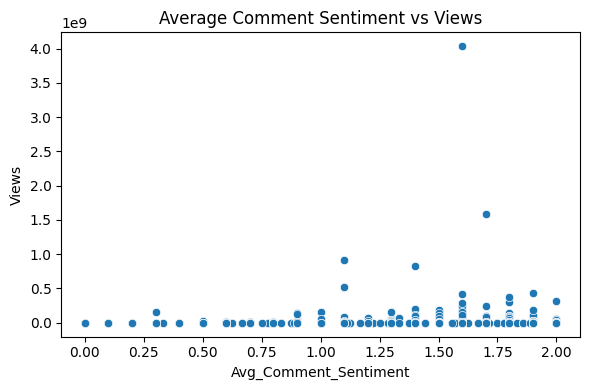

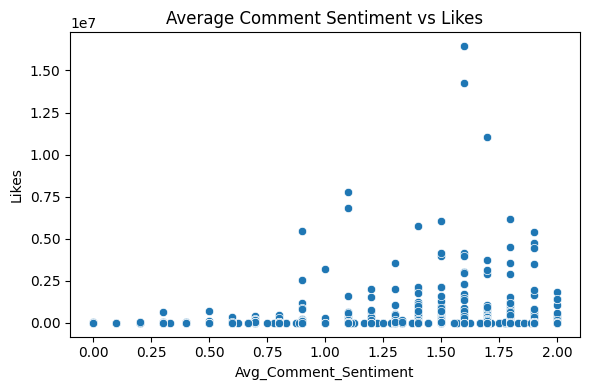

In [23]:
# Save sentiment vs views plot
plt.figure(figsize=(6, 4))
sns.scatterplot(data=merged_df, x='Avg_Comment_Sentiment', y='Views')
plt.title('Average Comment Sentiment vs Views')
plt.tight_layout()
plt.savefig('avg_sentiment_vs_views.png')

# Save sentiment vs likes plot
plt.figure(figsize=(6, 4))
sns.scatterplot(data=merged_df, x='Avg_Comment_Sentiment', y='Likes')
plt.title('Average Comment Sentiment vs Likes')
plt.tight_layout()
plt.savefig('avg_sentiment_vs_likes.png')

### 📊 Comparing Model Performance

We evaluate the two transformer-based models—**RoBERTa** (fine-tuned) and **Zero-shot BART**—using the same metrics as our traditional ML models.

- Predictions are compared to the ground truth sentiment labels.
- Accuracy and weighted F1 scores are computed and appended to the existing results list.
- A grouped bar chart is plotted to visually compare the performance (Accuracy vs F1 Score) of all models.

The final chart is saved as `model_comparison_scores.png` for reference and reporting.


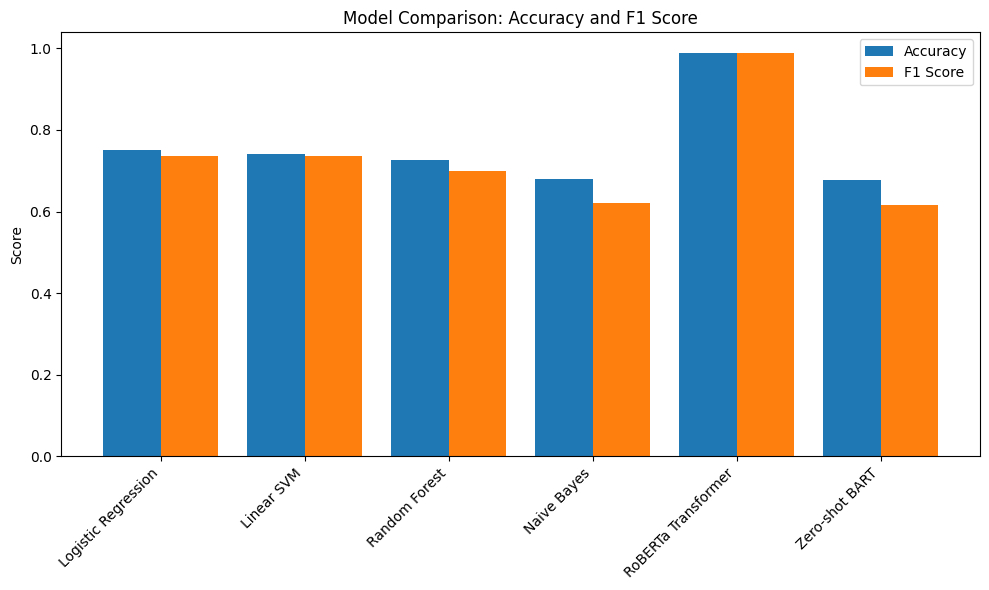

In [24]:
# Evaluate Transformer model
y_predt = comments_df['Transformer_Prediction']
acc_roberta = accuracy_score(y_true, y_predt)
f1_roberta = f1_score(y_true, y_predt, average='weighted')
model_names.append("RoBERTa Transformer")
accuracies.append(acc_roberta)
f1_scores.append(f1_roberta)

# Evaluate Zero-shot model
y_predz = comments_df['ZeroShot_Prediction']
acc_zeroshot = accuracy_score(y_true, y_predz)
f1_zeroshot = f1_score(y_true, y_predz, average='weighted')
model_names.append("Zero-shot BART")
accuracies.append(acc_zeroshot)
f1_scores.append(f1_zeroshot)

x = range(len(model_names))
plt.figure(figsize=(10, 6))

plt.bar(x, accuracies, width=0.4, label='Accuracy', align='center')
plt.bar([i + 0.4 for i in x], f1_scores, width=0.4, label='F1 Score', align='center')

plt.xticks([i + 0.2 for i in x], model_names, rotation=45, ha='right')
plt.ylabel('Score')
plt.title('Model Comparison: Accuracy and F1 Score')
plt.legend()
plt.tight_layout()
plt.savefig("model_comparison_scores.png")
plt.show()